**Importing helper functions**

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-02-19 16:58:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-19 16:58:01 (108 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

**Get a Text dataset**

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-02-19 16:58:03--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.128, 74.125.124.128, 172.217.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip.2’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.007s  

2023-02-19 16:58:03 (87.4 MB/s) - ‘nlp_getting_started.zip.2’ saved [607343/607343]



In [ ]:
# Turn .csv files into pandas DataFrame's
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42) # shuffle with random_state=42 for reproducibility
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# How many examples of each class?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many samples total?
print(f"Total training samples: {len(train_df)}")
print(f"Total test samples: {len(test_df)}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 7613
Total test samples: 3263
Total samples: 10876


In [ ]:
#Train Test split

from sklearn.model_selection import train_test_split
train_sentences,val_sentences,train_labels,val_labels=train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                       train_df_shuffled["target"].to_numpy(),
                                                                       test_size=0.1,
                                                                       random_state=42)


In [ ]:
len(train_sentences),len(val_sentences),len(train_labels),len(val_labels)

(6851, 762, 6851, 762)

In [ ]:
train_sentences[:10]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk',
       '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
       'destroy the free fandom honestly',
       'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
       '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
       'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
      dtype=object)

In [ ]:
train_labels[:10]

array([0, 0, 1, 0, 0, 1, 1, 0, 1, 1])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [ ]:
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None)

In [ ]:

# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
# Let's visualize some random training examples
import random

In [ ]:
random_sentence=random.choice(train_sentences)

In [ ]:
print(f"random sentences:\n{random_sentence}\n\vectorized version")
text_vectorizer([random_sentence])

random sentences:
@mickinyman @TheAtlantic That or they might be killed in an airplane accident in the night a car wreck! Politics at it's best.
ectorized version


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   1, 7671,   16,   53,   64,  843,   21,  111,    4,   39,  444,
         128,    4,    2,  285]])>

In [ ]:
words_in_vocab=text_vectorizer.get_vocabulary()
top_5_words=words_in_vocab[:5]
lowest_5_words=words_in_vocab[-5:]
print(f"Number of vocabs {len(words_in_vocab)}")
print(f"Top 5 words {top_5_words}")
print(f"Lowest 5 words {lowest_5_words}")


Number of vocabs 10000
Top 5 words ['', '[UNK]', 'the', 'a', 'in']
Lowest 5 words ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
tf.random.set_seed(42)

In [ ]:
from tensorflow.keras import layers

In [ ]:
embedding=layers.Embedding(input_dim=max_vocab_length,
                           output_dim=128,
                           embeddings_initializer="uniform",
                            input_length=max_length, # how long is each input
                            name="embedding_1")
embedding

In [ ]:
random_sentence=random.choice(train_sentences)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")
sample_embed=embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
#ThingsIhate 
Watching someone you care about head into total destruction and not being able to do anything.      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02009657, -0.0270954 , -0.01430706, ..., -0.0386144 ,
          0.03411758,  0.04059211],
        [-0.03585543, -0.04465336, -0.00254754, ..., -0.02770931,
          0.00609374,  0.04504904],
        [ 0.00130109, -0.04869313,  0.01392374, ..., -0.02093907,
         -0.00555853,  0.02729476],
        ...,
        [-0.00695599,  0.03443916,  0.01806894, ...,  0.00944892,
         -0.00163021,  0.0427779 ],
        [-0.01301821,  0.02273177, -0.0263675 , ...,  0.00079105,
          0.00090804, -0.00229546],
        [ 0.0032012 , -0.00653354,  0.03671474, ...,  0.02847096,
          0.02788465, -0.03134727]]], dtype=float32)>

In [ ]:
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.02009657, -0.0270954 , -0.01430706, -0.01542802, -0.01318973,
        0.02874779,  0.01485235,  0.00134348,  0.02207002,  0.02142211,
       -0.02841728, -0.04971891,  0.00716364, -0.03388342, -0.02773552,
        0.00412637, -0.02514774, -0.02258549, -0.02541839, -0.01921167,
       -0.04736428, -0.04046401,  0.00553095, -0.043783  ,  0.03315899,
       -0.00492587, -0.01519161,  0.03697077, -0.04486817,  0.01912074,
        0.01326097, -0.0182194 ,  0.02103933,  0.04258544, -0.04423468,
        0.02905161, -0.0141917 , -0.0475778 ,  0.04736144,  0.01361333,
       -0.0199471 , -0.00325284,  0.0288418 ,  0.04158426,  0.01315421,
       -0.04999269,  0.01902639, -0.04956026, -0.02708536,  0.01680542,
        0.00364548, -0.03999399, -0.04625577,  0.03895842,  0.04802186,
        0.02984523,  0.01111516,  0.02839737,  0.02302518, -0.03859788,
        0.02481408, -0.04066672,  0.03548848, -0.042643  , -0.03797941,
       -0.048616

Naive Bayes 

---



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0=Pipeline([("tfidf",TfidfVectorizer()),
                  ("clf",MultinomialNB() )



])
model_0.fit(train_sentences,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
baseline_score=model_0.score(val_sentences,val_labels)

In [ ]:
print(baseline_score)

0.7926509186351706


In [ ]:
baseline_preds=model_0.predict(val_sentences)

In [ ]:
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
def calculate_results(y_true,y_pred):
  model_accuracy=accuracy_score(y_true,y_pred)*100
  model_precision,model_recall,model_f1score,_=precision_recall_fscore_support(y_true,y_pred,average='weighted')
  model_results={
      "Accuracy":model_accuracy,
      "Precision":model_precision,
      "Recall": model_recall,
      "F1_score":model_f1score
      
  }
  return model_results





{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1_score': 0.7862189758049549}

In [ ]:
calculate_results(val_labels,baseline_preds)

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1_score': 0.7862189758049549}

In [ ]:
# Calculate model results
baseline_results = calculate_results(val_labels, baseline_preds)
baseline_results

{'Accuracy': 79.26509186351706,
 'Precision': 0.8111390004213173,
 'Recall': 0.7926509186351706,
 'F1_score': 0.7862189758049549}

In [ ]:
from helper_functions import create_tensorboard_callback

In [ ]:
SAVE_DIR="MODEL_LOGS"


In [ ]:
from tensorflow.keras import layers
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=embedding(x)
x=layers.GlobalAveragePooling1D()(x)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_1=tf.keras.Model(inputs,outputs,name="model_1")

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d_2   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-tra

In [ ]:
model_1_history=model_1.fit(train_sentences,
                            train_labels,
                            epochs=5,
                            validation_data=(val_sentences,val_labels),
                            callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,experiment_name="model_1")])

Saving TensorBoard log files to: MODEL_LOGS/model_1/20230219-165805
Epoch 1/5
215/215 [==============================] - 12s 50ms/step - loss: 0.6115 - accuracy: 0.6894 - val_loss: 0.5377 - val_accuracy: 0.7533
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4428 - accuracy: 0.8186 - val_loss: 0.4696 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 4s 21ms/step - loss: 0.3478 - accuracy: 0.8606 - val_loss: 0.4591 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.2863 - accuracy: 0.8914 - val_loss: 0.4639 - val_accuracy: 0.7887
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.2394 - accuracy: 0.9117 - val_loss: 0.4761 - val_accuracy: 0.7861


In [ ]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 4ms/step - loss: 0.4761 - accuracy: 0.7861


[0.4760923981666565, 0.7860892415046692]

In [ ]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.04415652,  0.01303022, -0.06226079, ...,  0.03692568,
          0.04803749, -0.02495216],
        [ 0.01604947,  0.03044293, -0.05192966, ...,  0.02519883,
          0.00043188,  0.02507285],
        [ 0.01006358,  0.0008535 , -0.02121205, ...,  0.0699454 ,
         -0.00813408, -0.00369001],
        ...,
        [ 0.04643605,  0.02249733, -0.04830451, ...,  0.0453542 ,
         -0.02980725,  0.02763053],
        [ 0.03304956,  0.03389081, -0.00220724, ...,  0.07245356,
          0.02483193, -0.0828781 ],
        [ 0.03017512,  0.07180488, -0.05098289, ...,  0.08284644,
          0.08129164, -0.02410511]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
model_1_preds=model_1.predict(val_sentences)

24/24 [==============================] - 0s 4ms/step


In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_1_preds = tf.squeeze(tf.round(model_1_preds))
model_1_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_1_results = calculate_results(val_labels, model_1_preds)
model_1_results

{'Accuracy': 78.60892388451444,
 'Precision': 0.7903277546022673,
 'Recall': 0.7860892388451444,
 'F1_score': 0.7832971347503846}

In [ ]:
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")
inputs=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(inputs)
x=model_2_embedding(x)
print(x.shape)
x=layers.LSTM(64)(x)
print(x.shape)
outputs=layers.Dense(1,activation="sigmoid")(x)
model_2=tf.keras.Model(inputs,outputs,name="Model_2_RNN")


(None, 15, 128)
(None, 64)


In [ ]:

# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "Model_2_RNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_____________________________________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "LSTM")])

Saving TensorBoard log files to: MODEL_LOGS/LSTM/20230219-165849
Epoch 1/5
215/215 [==============================] - 10s 36ms/step - loss: 0.5120 - accuracy: 0.7424 - val_loss: 0.4567 - val_accuracy: 0.7743
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3186 - accuracy: 0.8717 - val_loss: 0.5126 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2209 - accuracy: 0.9159 - val_loss: 0.5820 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1575 - accuracy: 0.9453 - val_loss: 0.6276 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1110 - accuracy: 0.9600 - val_loss: 0.8242 - val_accuracy: 0.7638


In [ ]:
model_2_pred_probs=model_2.predict(val_sentences)

24/24 [==============================] - 1s 5ms/step


In [ ]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'Accuracy': 76.37795275590551,
 'Precision': 0.764383846466808,
 'Recall': 0.7637795275590551,
 'F1_score': 0.7621412379223811}

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x) 
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of the GRU model
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru_2 (GRU)                 (None, 64)                37248     
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Fit model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: MODEL_LOGS/GRU/20230219-165912
Epoch 1/5
215/215 [==============================] - 13s 41ms/step - loss: 0.5272 - accuracy: 0.7273 - val_loss: 0.4522 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3207 - accuracy: 0.8679 - val_loss: 0.4918 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2188 - accuracy: 0.9167 - val_loss: 0.5549 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1579 - accuracy: 0.9445 - val_loss: 0.6139 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1186 - accuracy: 0.9603 - val_loss: 0.6013 - val_accuracy: 0.7795


In [ ]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.44154894],
        [0.89361787],
        [0.9974699 ],
        [0.13274898],
        [0.01219988],
        [0.98933244],
        [0.64955413],
        [0.9963413 ],
        [0.99644285],
        [0.37060392]], dtype=float32))

In [ ]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_3_preds)
model_3_results

{'Accuracy': 77.95275590551181,
 'Precision': 0.7792908164213541,
 'Recall': 0.7795275590551181,
 'F1_score': 0.7788660432741207}

In [ ]:

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

In [ ]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:

# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: MODEL_LOGS/bidirectional_RNN/20230219-165934
Epoch 1/5
215/215 [==============================] - 13s 39ms/step - loss: 0.5103 - accuracy: 0.7468 - val_loss: 0.4576 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3137 - accuracy: 0.8716 - val_loss: 0.5099 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2138 - accuracy: 0.9168 - val_loss: 0.5600 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1484 - accuracy: 0.9488 - val_loss: 0.6513 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1072 - accuracy: 0.9622 - val_loss: 0.6683 - val_accuracy: 0.7598


In [ ]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 5ms/step


array([[0.04254569],
       [0.8440713 ],
       [0.99855465],
       [0.13781863],
       [0.00680063],
       [0.9953963 ],
       [0.84595513],
       [0.99935263],
       [0.99896276],
       [0.24294941]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'Accuracy': 75.98425196850394,
 'Precision': 0.7594780880165999,
 'Recall': 0.7598425196850394,
 'F1_score': 0.7590768821741806}

In [ ]:
# Test out the embedding, 1D convolutional and max pooling
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D() 
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.02425532, -0.01592502,  0.03480468, ...,  0.01639483,
           0.0222107 , -0.00100231],
         [-0.01255441,  0.06528822, -0.0486183 , ...,  0.01201552,
           0.09371695, -0.0363835 ],
         [ 0.03618946,  0.03029585, -0.03185757, ...,  0.05148547,
           0.04294623, -0.04169232],
         ...,
         [ 0.04415652,  0.01303022, -0.06226079, ...,  0.03692568,
           0.04803749, -0.02495216],
         [ 0.04415652,  0.01303022, -0.06226079, ...,  0.03692568,
           0.04803749, -0.02495216],
         [ 0.04415652,  0.01303022, -0.06226079, ...,  0.03692568,
           0.04803749, -0.02495216]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.05165617, 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.01741917, 0.05546533, 0.00244522, 0.07412411,
          0.05799025, 0.        , 0.        , 0.03166452, 0.        ,
          0.06081505, 0.

In [ ]:
# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_5 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_5 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 1)              

In [ ]:

# Fit the model
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "Conv1D")])

Saving TensorBoard log files to: MODEL_LOGS/Conv1D/20230219-165959
Epoch 1/5
215/215 [==============================] - 9s 33ms/step - loss: 0.5654 - accuracy: 0.7136 - val_loss: 0.4721 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3400 - accuracy: 0.8625 - val_loss: 0.4641 - val_accuracy: 0.7940
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2103 - accuracy: 0.9219 - val_loss: 0.5286 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.1344 - accuracy: 0.9564 - val_loss: 0.5974 - val_accuracy: 0.7756
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0947 - accuracy: 0.9685 - val_loss: 0.6529 - val_accuracy: 0.7861


In [ ]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.55609274],
       [0.7714911 ],
       [0.99961424],
       [0.09558979],
       [0.00299611],
       [0.9948685 ],
       [0.9376847 ],
       [0.9983499 ],
       [0.99925524],
       [0.20058012]], dtype=float32)

In [ ]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_5 evaluation metrics 
model_5_results = calculate_results(y_true=val_labels, 
                                    y_pred=model_5_preds)
model_5_results

{'Accuracy': 78.60892388451444,
 'Precision': 0.7892068285860523,
 'Recall': 0.7860892388451444,
 'F1_score': 0.7837076401553273}

In [ ]:
sample_sentence = "There's a flood in my street!"

In [ ]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01157028  0.0248591   0.02878048 -0.012715    0.03971538  0.0882776
  0.02680984  0.05589836 -0.0106873  -0.00597291  0.00639323 -0.01819518
  0.00030813  0.09105888  0.05874644 -0.03180628  0.01512474 -0.05162929
  0.00991367 -0.06865347 -0.04209306  0.02678981  0.03011006  0.00321069
 -0.00337973 -0.04787357  0.0226672  -0.00985925 -0.04063613 -0.01292092
 -0.04666384  0.05630299 -0.03949255  0.00517686  0.02495829 -0.0701444
  0.02871508  0.04947684 -0.00633979 -0.08960192  0.02807118 -0.00808364
 -0.01360602  0.0599865  -0.10361787 -0.05195374  0.00232954 -0.02332531
 -0.03758105  0.03327728], shape=(50,), dtype=float32)


In [ ]:

# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [ ]:
sentence_encoder_layer=hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                      input_shape=[],
                                      dtype=tf.string,
                                      trainable=False,
                                      name="USE")

In [ ]:
model_6=tf.keras.Sequential([
    
    sentence_encoder_layer,
    layers.Dense(64,activation="relu"),
    layers.Dense(1,activation="sigmoid"),
    
], name="USE")

model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_19 (Dense)            (None, 64)                32832     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, 
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: MODEL_LOGS/tf_hub_sentence_encoder/20230219-170032
Epoch 1/5
215/215 [==============================] - 8s 18ms/step - loss: 0.5053 - accuracy: 0.7803 - val_loss: 0.4478 - val_accuracy: 0.7992
Epoch 2/5
215/215 [==============================] - 3s 13ms/step - loss: 0.4147 - accuracy: 0.8142 - val_loss: 0.4364 - val_accuracy: 0.8097
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.3997 - accuracy: 0.8209 - val_loss: 0.4323 - val_accuracy: 0.8123
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3922 - accuracy: 0.8266 - val_loss: 0.4284 - val_accuracy: 0.8097
Epoch 5/5
215/215 [==============================] - 3s 16ms/step - loss: 0.3855 - accuracy: 0.8286 - val_loss: 0.4301 - val_accuracy: 0.8150


In [ ]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[0.15158102],
       [0.73899835],
       [0.9881728 ],
       [0.20980418],
       [0.7316982 ],
       [0.68147427],
       [0.98011255],
       [0.9772425 ],
       [0.9243774 ],
       [0.08836946]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'Accuracy': 81.49606299212599,
 'Precision': 0.8175707797736699,
 'Recall': 0.8149606299212598,
 'F1_score': 0.8133343159175271}

In [ ]:
import numpy as np

In [ ]:

# One kind of correct way (there are more) to make data subset
# (split the already split train_sentences/train_labels)
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [ ]:
# Clone model_6 but reset weights
model_7 = tf.keras.models.clone_model(model_6)

# Compile model
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary (will be same as model_6)
model_7.summary()

Model: "USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_19 (Dense)            (None, 64)                32832     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 10% of the training data
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_sentence_encoder")])

Saving TensorBoard log files to: MODEL_LOGS/10_percent_tf_hub_sentence_encoder/20230219-173032
Epoch 1/5
22/22 [==============================] - 1s 37ms/step - loss: 0.3678 - accuracy: 0.8557 - val_loss: 0.4829 - val_accuracy: 0.7848
Epoch 2/5
22/22 [==============================] - 1s 24ms/step - loss: 0.3445 - accuracy: 0.8644 - val_loss: 0.4786 - val_accuracy: 0.7822
Epoch 3/5
22/22 [==============================] - 0s 23ms/step - loss: 0.3250 - accuracy: 0.8761 - val_loss: 0.4807 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 0s 23ms/step - loss: 0.3082 - accuracy: 0.8776 - val_loss: 0.4813 - val_accuracy: 0.7835
Epoch 5/5
22/22 [==============================] - 1s 24ms/step - loss: 0.2936 - accuracy: 0.8936 - val_loss: 0.4838 - val_accuracy: 0.7835


In [ ]:
# Make predictions with the model trained on 10% of the data
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


array([[0.19754434],
       [0.92752033],
       [0.96908647],
       [0.1827032 ],
       [0.46709913],
       [0.9184971 ],
       [0.92962545],
       [0.9066994 ],
       [0.9237101 ],
       [0.06929487]], dtype=float32)

In [ ]:
# Convert prediction probabilities to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model results
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'Accuracy': 78.34645669291339,
 'Precision': 0.785851650078301,
 'Recall': 0.7834645669291339,
 'F1_score': 0.7813141680786296}

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results,
                                  "tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy,Precision,Recall,F1_score
baseline,79.265092,0.811139,0.792651,0.786219
simple_dense,78.608924,0.790328,0.786089,0.783297
lstm,76.377953,0.764384,0.763780,0.762141
gru,77.952756,0.779291,0.779528,0.778866
bidirectional,75.984252,0.759478,0.759843,0.759077
conv1d,78.608924,0.789207,0.786089,0.783708
tf_hub_sentence_encoder,81.496063,0.817571,0.814961,0.813334
tf_hub_10_percent_data,78.346457,0.785852,0.783465,0.781314


In [ ]:
# Reduce the accuracy to same scale as other metrics
all_model_results["Accuracy"] = all_model_results["Accuracy"]/100

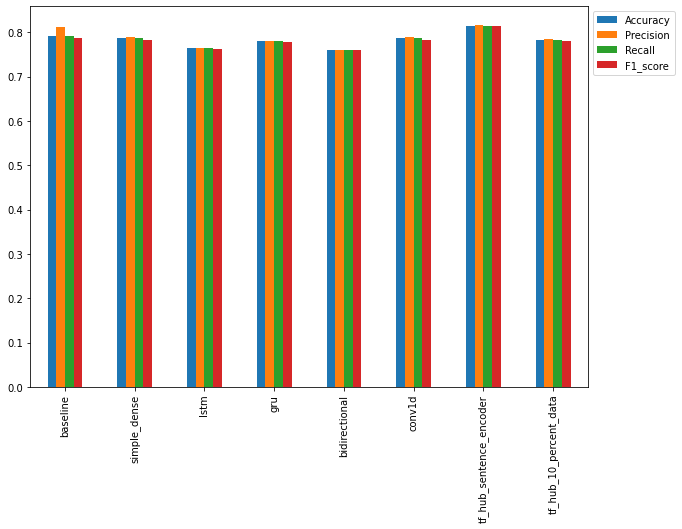

In [ ]:

# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

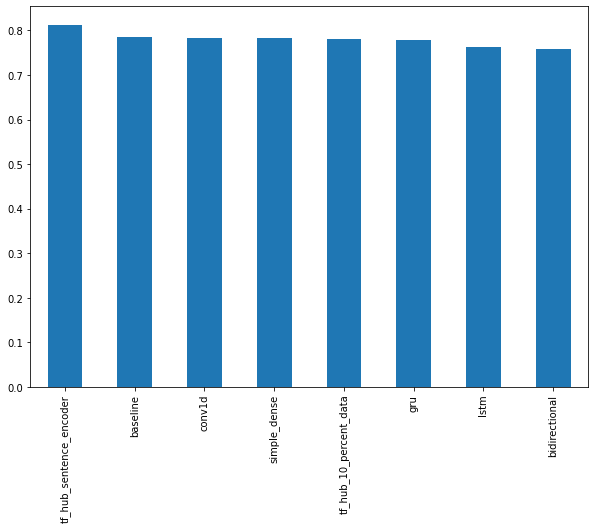

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("	F1_score", ascending=False)["F1_score"].plot(kind="bar", figsize=(10, 7));